<a href="https://colab.research.google.com/github/arnavvats/pytorch-cnns/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL STYLE TRANSFER ON IMAGES WITH PYTORCH

## Introduction

### About Colab

As a student , I have limited access to computational resources for using cloud GPUs , training large models or downloading  heavy datasets. Colab is a boon for students and when used in the right way , it can be used to perform heavy training tasks without hindrances .



In this notebook , we will run neural style transfer on an image, to change its texture according to a style image.

### About Neural Style Transfer

This algorithm was introduced by Gatys et al in 2015 (https://arxiv.org/abs/1508.06576).

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

<img src="https://cdn-images-1.medium.com/max/1600/1*MAjeF5fiRosZP6PMtAQp_Q.jpeg">

#Content Image +  Style Image &nbsp;--> &nbsp;Generated Image

---



### Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

Following the original [NST Paper](https://arxiv.org/abs/1508.06576') we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers).

## Setting up the notebook

First of all, set the runtime to GPU. This is important for speed of model training. The option can be found in the Runtime tab at the top. 

Do not select TPU as PyTorch does not have support for it at the time of writing.

To download our datasets , we will  be using kaggle cli.

If you do not have a kaggle account / cli , please go to [kaggle](https://kaggle.com) and generate one.

You can find your api key on your account page.


### Setting up kaggle cli and drive

Set your kaggle username and api key to the virtual environment.

We will mount our drive onto the colab notebook so that we can **keep saving our progress between checkpoints.**

This is because a **colab instance stops running after 90 minutes of inactivity/disconnection** and **gets terminated after 12 hours**. In both the cases all our variables would be lost, and after the runtime terminates, the files on the instance would disappear. So if we're training our model , which could take long times, **we should save our model to the drive on every few iterations**, as the drive storage is persistent.



In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'your-kaggle-username' # REPLACE WITH YOUR KAGGLE USERNAME
os.environ['KAGGLE_KEY'] = 'kaggle-key' # REPLACE WITH SECRET API KEY
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


You'll be asked to input a verification code, after which the drive will be mounted to your instance. \

Let's take a look.

In [2]:
drive_paths = os.listdir('/drive')
print(drive_paths)
drive_dir = os.path.join('/drive',drive_paths[0]) # path to mounted drive folder
# os.listdir(drive_dir) # Uncomment to see contents of your drive

['My Drive', '.Trash']


Generally the drive would be mounted inside the mount folder as 'My Drive'. You can list out the contents of this folder to verify it

We save the path to this folder in &nbsp; ```drive_dir ```

## Setting up the data


### Downloading the dataset

Now we shall download our kaggle dataset.

We have to download a set of artistic images , which will be used for the style and a set of general content images.


In [3]:
!kaggle datasets download ikarus777/best-artworks-of-all-time
!kaggle datasets download -d duttadebadri/image-classification

100% 2.16G/2.16G [00:20<00:00, 163MB/s]
100% 2.16G/2.16G [00:20<00:00, 111MB/s]
 99% 2.32G/2.34G [00:23<00:00, 151MB/s]
100% 2.34G/2.34G [00:23<00:00, 106MB/s]


**If you get a 404 Error** , this is becuase of some issue with Kaggle cli in gpu instances.

You can fix this by selecting Runtime and Resetting the runtimes ,  **remember to select reset and not restart**.

Now we shall unzip our data and get a look at it. These datasets would disappear if the runtime restarts , but they be persistent upon resetting.

In [4]:
!ls

best-artworks-of-all-time.zip  image-classification.zip  sample_data


In [5]:
!unzip -qq -n best-artworks-of-all-time.zip -d style_images
!ls ./style_images


artists.csv  images.zip  resized.zip


We unzip the style images to the styled_images folder and see two zip files - images.zip and resized.zip.

It would be safer to use the resized images becuase of consistency and less loading time, so we should inflate it and use it for our model.

###  Unzipping and saving data location

We now unzip our data and save the locations for further use.

In [6]:
!unzip -qq -n ./style_images/resized.zip -d ./style_images/
!ls ./style_images

artists.csv  images.zip  __MACOSX  resized  resized.zip


Now we shall inflate the zip file for content images.

In [7]:
!unzip -qq -n image-classification.zip -d content_images
!ls ./content_images

images.zip  test.zip  validation.zip


In [8]:
!unzip -qq -n ./content_images/images.zip -d ./content_images
!ls ./content_images/images

images/architecure/120px-Didvyžių_Šv._popiežiaus_Leono_II_bažnyčia.jpg:  mismatching "local" filename (images/architecure/120px-Didvy┼╛i┼│_┼аv._popie┼╛iaus_Leono_II_ba┼╛ny─Нia.jpg),
         continuing with "central" filename version
images/architecure/120px-Kutná_Hora,_Vnitřní_Město,_Chrám_sv._Barbory,_S_01.jpg:  mismatching "local" filename (images/architecure/120px-Kutn├б_Hora,_Vnit┼Щn├н_M─Ыsto,_Chr├бm_sv._Barbory,_S_01.jpg),
         continuing with "central" filename version
images/architecure/120px-Kutná_Hora,_Vnitřní_Město,_Chrám_sv._Barbory,_S_03.jpg:  mismatching "local" filename (images/architecure/120px-Kutn├б_Hora,_Vnit┼Щn├н_M─Ыsto,_Chr├бm_sv._Barbory,_S_03.jpg),
         continuing with "central" filename version
images/architecure/80px-Kutná_Hora_-_vnější_opěrné_oblouky_z_Svaté_Barbory1.jpg:  mismatching "local" filename (images/architecure/80px-Kutn├б_Hora_-_vn─Ыj┼б├н_op─Ыrn├й_oblouky_z_Svat├й_Barbory1.jpg),
         continuing with "central" filename version
images/arch

Here the images are in a subfolder structure. We need to put all of them in a single folder for our data loader to work easier.

In [0]:
!mkdir -p ./content_images/_images
!find ./content_images/images -type f -print0 | xargs -0 mv -t ./content_images/_images
!rm -rf ./content_images/images
!mv ./content_images/_images ./content_images/images

Now we have all the images in a single folder 

```
content_images/images
```



## Implementing NST

### Importing Packages and Selecting a Device

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
%matplotlib inline


Now we will select the device to run the model on, ie, GPU or CPU. Running the algorithm on a GPU would be much faster and is recommended. PyTorch runs on GPUs with the help of underlying cuda libraries, the function  ```torch.cuda.is_available()``` tells us whether a GPU is available to run PyTorch on. 

In the next block , we will store the device the performations will occur on.



In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading and plotting images

Now we define
*  Batch size
* Image Loader and show functions

We are not using the conventional numpy methods becuase numpy only works on cpu and so our model would be slowed down . So we make use of PyTorch Tensors strictly.

We have defined a square batch size for all images . This can cause heavy distortions in rectangular images or images of small size . We can write a small function to clear out these if they hurt our model.



In [0]:
imsize = 512 if torch.cuda.is_available() else 128 # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)), # enforce constant height and width for all images
    transforms.ToTensor()
])

unloader = transforms.ToPILImage('RGB') # enforce 3-channels encoded image

def image_loader(image_path):
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0) # Add a dimension at the start for batch processing
    return image.to(device, torch.float)

def imshow(tensor, title = None):
  image = tensor.cpu().clone() # Clone tensor to prevent changes on original model
  image = image.squeeze(0)  # Remove batch dimension
  image = unloader(image)
  plt.imshow(image)
  plt.axis('off')
  if title is not None:
    plt.title(title)
  

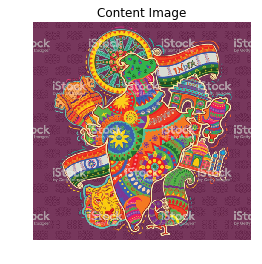

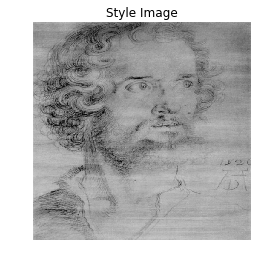

In [13]:
content_img = image_loader('./content_images/images/0 (2).jpg')
style_img = image_loader('./style_images/resized/Albrecht_Dürer_1.jpg')

plt.figure(figsize = (4,4))
imshow(content_img, 'Content Image')
plt.figure(figsize = (4,4))
imshow(style_img, 'Style Image')


### Pre-trained VGG19 Model

Concisely, our network will take a VGG19 model which is pretrained to classify a lot of images, which means it can effectively recognize the content and style of an image.

We can roughly say that
*   The style of an image can be represented by  the activations in the initial layers of the network. This is because the initial layers work on small patches of the image, so they can be used to capture the texture and small details.

*   The final layers can be represented as the content of the image , since they see the larger picture.

Thus we can define our loss functions based on these layers of the network.

In [42]:
cnn = models.vgg19(pretrained = True)
cnn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In neural style transfer, typically the first 5 convolutional layers are used for the style loss and the last convolutional layer is used for content losss.

This VGG model has 2 modules, features and classifier .

The classifier module can safely be dropped as it would be of no use in calculating the loss function.

In [0]:
cnn = cnn.features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


The PyTorch docs mention the mean and std-deviation of the inputs these were trained on, hence it would be good to normalize the input before sending them to the network.

In [0]:
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # Transform mean and std tensor to C x 1 x 1 for broadcasting
    # with tensors of shape B x C x H x W
    self.mean = torch.tensor(mean).view(-1,1,1)
    self.std = torch.tensor(std).view(-1,1,1)
    
  def forward(self, img):
    # Normalize the image
    return (img - self.mean) / self.std

We initialized `Normalization` as a `module` instead of `function` because it would be convenient to put directly into the `nn.Sequential` module.

This module would not affect the backpropagation gradients because it's derivative is always a constant , hence this was initialized as a class just for simpler-sweeter syntax.

We will come back to this part after we write the content and the style cost.

### The  Neural Style Transfer

Before moving further, lets have a clear understanding of what the process would be :

*   First we will generate a white noise image, ie, an image with random pixel values.
*  Now we will run our model on the generated image, the content image and the style image.
* Gradient descent will be performed on the noise input of the generated input, to minimize content loss w.r.t content-image and style loss w.r.t style image.
* We will train the model on numerous epochs until the loss almost stops decreasing.
* The final generated image would have the preferred style and content.



#### Content Cost Function

The method used in the paper is

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$



Here, aC and aG are activations of the content layer.  We will use mean squared error loss which is the same except instead of 4, the loss would be divided by the batch size.



In [0]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # we 'detach' the target content from the tree, so that during
    # backprop its values are considered as static.
    self.target = target.detach()
    
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input
    

#### Style Cost Function

For this, the style matrix (a Gram matrix) is created.



**The Gram Matrix**

A Gram matrix is a matrix of dot products , whose entries are  ${\displaystyle G_{ij} = v_{i} ^ T v_{j}}$

For two dimension vectors , Gram matrix is  ${\displaystyle A ^ T A }$

The Gram matrix calculates the correlation between different elements of a vector.

Hence the Gram matrix for the style layers of images should be as similar as possible.

In [0]:
def gram_matrix(input):
  a, b, c, d = input.size()
  
  features = input.view(a * b, c * d)
  
  G = torch.mm(features, features.t())
  ## Normalize the Gram matrix
  return G.div(a * b * c * d)

**The Style Cost**

The style cost is similar to the content cost except for one small tweak.

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$


The loss function is divided by the squares of the input shapes. However , since we have normalized our Gram matrix in the definition itself, we can just calculate the mse loss.

In [0]:
class StyleLoss(nn.Module):
  
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
    
  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

#### Back To The Model

According to the literature , 

The best layers to perform style transfer would be
```conv_1_1, conv_2_1, conv_3_1, conv_4_1, conv_5_1```
Each of the loss from these layers will be given a weight of 0.2 .

The best layer to perform content transfer would be  ```conv_4_2```, which is an intermediate layer.

You might be confused by the terminology , lets see what these numbers mean.

In [44]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

Taking a look at the network , the general architecture is

conv -> relu -> conv -> relu   . . .  -> pool

So conv_1_1 would be the first  layer of the 1st chain , before a pooling layer breaks the chain, ie, layer 0.

Similarly , conv_4_3 is layer 21,  the 2nd  layer after the 4th pooling layer is encountered.


Now we can write a function that computes the style and weight losses.

In [0]:
content_layers_default = ['conv_4_3']
style_layers_default = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']

def get_style_model_and_loss(cnn, normalization_mean, normalization_std, style_img,
                            content_img, content_layers=content_layers_default,
                            style_layers = style_layers_default):
  cnn = copy.deepcopy(cnn)
  
  #normalization module
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  
  # just in order to have an iterable access to or list of content/style loss
  content_losses = []
  style_losses = []
  
  model = nn.Sequential(normalization)
  
  i = 1
  j = 1
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      name = 'conv_{}_{}'.format(i,j)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}_{}'.format(i, j)
      # The in-place version doesn't play very nicely with ContentLoss and
      # StyleLoss we insert below. So we replace with out-of-place ones here.
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}_{}'.format(i, j)
      
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}_{}'.format(i, j)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      
    model.add_module(name, layer)
    if name in content_layers:
      #add content_loss
      
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("Content_loss_{}_{}".format(i, j), content_loss)
      content_losses.append(content_loss)
      
    if name in style_layers:
      # add style loss
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("Style_loss_{}_{}".format(i, j), style_loss)
      style_losses.append(style_loss)
      
    # Reset the indexes since pooling layer is encountered
    if isinstance(layer, nn.MaxPool2d):
      j = 0
      i += 1
    j += 1

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
      
  model = model[:(i + 1)]
  return model, style_losses, content_losses

    

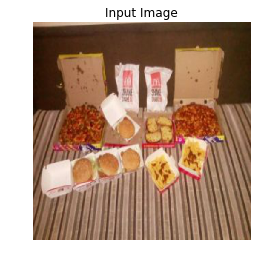

In [106]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title = 'Input Image')

#### Gradient Descent

As Leon Gatys, the author of the algorithm, we will use L-BFGS algorithm to run our gradient descent. Unlike training a network , we want to train the input image in order to minimize the content / style losses. We will create a PyTorch L-BGFS optimizer ```optim.LBGFS``` and pass our image to it as tensor to optimize.




In [0]:
def get_input_optimizer(input_img):
  # this line to show that input is a parameter that requires a gradient
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

Finally, we must define a function that performs the neural transfer. For each iteration of the network, it is fed an updated input and computes
new losses. We will run the ```backward``` methods of each loss module to dynamically compute their gradients. The optimizer requires a "closure function", which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                      content_img, style_img, input_img, num_steps = 3000,
                      style_weight = 100000, content_weight = 10):
  """Run the style transfer."""
  print('Building the style transfer model...')
  model, style_losses, content_losses = get_style_model_and_loss(cnn, normalization_mean, normalization_std,
                                                                  style_img, content_img)
  optimizer = get_input_optimizer(input_img)
  
  print('Optimizing...')
  run = [0]
  while run[0] <= num_steps:
    def closure():
      # correct the values of updated input image
      input_img.data.clamp_(0, 1)
      
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
        
      style_score *= style_weight
      content_score *= content_weight
      loss = style_score + content_score
      
      loss.backward()
      
      run[0] += 1
      if run[0] % 100 == 0:
        print("run {}".format(run))
        print("Style loss: {} Content Loss: {}".format(
          style_score, content_score
        ))
        print()
        
      return style_score + content_score
    
    optimizer.step(closure)
    
    # a last correction...
    input_img.data.clamp_(0, 1)
    
  return input_img

Now lets select a content image and a style image for our neural transfer. You can select any pair of images from the folders and see the results.

In our defined function , we have style weights and content weights which regulate on which loss should get more focus from our optimizer , by scaling them up/down.

It was observed that starting from a white noise image, it took a lot of iterations to converge , what we can do instead is copy the content image , and set the content weights much smaller than the style weights , and we'd get a style transfer in fewer iterations.

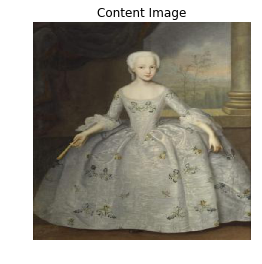

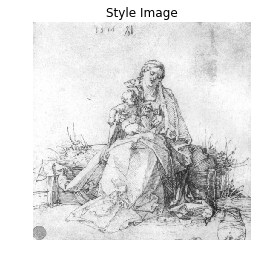

In [148]:
content_img = image_loader('./content_images/images/0824.jpg')
style_img = image_loader('./style_images/resized/Albrecht_Dürer_166.jpg')
plt.figure()
imshow(content_img, title = 'Content Image')
plt.show()
imshow(style_img, title = 'Style Image')
plt.show()

In [145]:

# input_img = torch.randn(content_img.data.size(), device=device)
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                           content_img, style_img, input_img)



Building the style transfer model...
Optimizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


run [100]
Style loss: 32.19243621826172 Content Loss: 16.627498626708984

run [200]
Style loss: 26.001338958740234 Content Loss: 13.77803897857666

run [300]
Style loss: 23.55401611328125 Content Loss: 12.59537124633789

run [400]
Style loss: 21.621257781982422 Content Loss: 11.925686836242676

run [500]
Style loss: 19.651464462280273 Content Loss: 11.871395111083984

run [600]
Style loss: 29.2526798248291 Content Loss: 22.26992416381836

run [700]
Style loss: 13.714561462402344 Content Loss: 12.061742782592773

run [800]
Style loss: 12.598410606384277 Content Loss: 11.234217643737793

run [900]
Style loss: 13.194777488708496 Content Loss: 12.087408065795898

run [1000]
Style loss: 87.98302459716797 Content Loss: 47.5347900390625

run [1100]
Style loss: 12.747713088989258 Content Loss: 13.952393531799316

run [1200]
Style loss: 11.241732597351074 Content Loss: 11.840600967407227

run [1300]
Style loss: 10.533692359924316 Content Loss: 11.015340805053711

run [1400]
Style loss: 9.986970

On 3000 iterations , it should take about 15-20 minutes. You can set it to fewer iterations to see results fast.

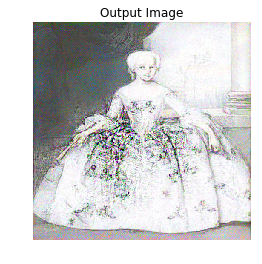

In [147]:
plt.figure()
imshow(output, title = 'Output Image')
plt.show()

Now we get a new image with a different style. Beautiful.